In [1]:
%%capture
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.3
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
import gdal 

In [2]:
from tqdm.autonotebook import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import rasterio

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


TF version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [3]:
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os 
from os.path import join, isdir, isfile
from tqdm.autonotebook import tqdm
import shutil

from tempfile import mkdtemp
def move(dataset):

    count = 0

    for folder in tqdm(os.listdir(os.getcwd())):
        if isdir(join(folder,"0")):
            for file in tqdm(os.listdir(join(folder,"0"))):
                if file.endswith(".tif"):
                    hr_file = join(folder,"0_hr","hr_" + file)
                    lr_file = join(folder,"0", file)

                    lr_dest = join("images", "0", "lr_" + str(count) + ".tif")
                    hr_dest = join("images", "0", "hr_" + str(count) + ".tif")

                    if isfile(hr_file) and isfile(lr_file):
                        shutil.move(hr_file, hr_dest)
                        shutil.move(lr_file, lr_dest)
                        count += 1
                    
        if isdir(join(folder,"1")):
            for file in tqdm(os.listdir(join(folder,"1"))):
                if file.endswith(".tif"):
                    hr_file = join(folder,"1_hr","hr_" + file)
                    lr_file = join(folder,"1", file)
                    
                    lr_dest = join("images", "1", "lr_" + str(count) + ".tif")
                    hr_dest = join("images", "1", "hr_" + str(count) + ".tif")
                    
                    if isfile(hr_file) and isfile(lr_file):
                        shutil.move(hr_file, hr_dest)
                        shutil.move(lr_file, lr_dest)
                        count += 1

In [5]:
from tempfile import mkdtemp


def load_images_test(image_dir):
    hr_name = join(mkdtemp(), 'hr.memmap')
    lr_name = join(mkdtemp(), 'lr.memmap')

    num_images = (len(glob.glob1("/content/images/1","*.tif")) + len(glob.glob1("/content/images/0","*.tif")))/2
    hr_mem = np.memmap(hr_name, dtype='float32', mode='w+', shape=(int(num_images),85,85,3))
    lr_mem = np.memmap(lr_name, dtype='float32', mode='w+', shape=(int(num_images),5))

    index = 0
    labels = []
    file_list = []

    for root, dirs, files in os.walk(image_dir):
        for file in tqdm(files):
            if (file.endswith(".tif") and file.startswith("hr_")):
                file_path = os.path.join(root, file)
                file_list.append(file_path)
                hr_image, _ = raster.load_image(file_path)
                lr_image, _ = raster.load_image(file_path.replace("hr_", "lr_"))
                label = int(basename(dirname(file_path)))
                
                labels.append(label)
                hr_mem[index,:,:,:] = resize(reshape_as_image(hr_image.read()), (85,85,3))
                lr_mem[index,:] = np.squeeze(np.squeeze(reshape_as_image(lr_image.read())))
                index += 1

    labels_array = np.asarray(labels)
    del labels

    return hr_mem, lr_mem, labels_array, file_list

In [6]:
!rm -rf dataset
!rm -rf images

In [ ]:
!cp "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Training Images/Hybrid CNN/lap_2018-07_site05_120m_RGB_cc.zip" .
!mkdir dataset
!mkdir images
!mkdir images/0/
!mkdir images/1/
!unzip lap_2018-07_site05_120m_RGB_cc.zip  -d dataset

In [8]:
move("/content/dataset")

In [9]:
model = load_model("/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Models/hybrid/")

In [10]:
from skimage.transform import resize
from os.path import basename, dirname
from rasterio.plot import reshape_as_image
import glob
from gis_utils import raster

hr, lr, labels, files = load_images_test("images")

In [11]:
predictions = model.predict([lr,hr])

column_names = ["prediction","p_0","p_1","filename"]
result_df = pd.DataFrame(columns=column_names)


#associate filenames and classification for each prediction
for i,prediction in tqdm(enumerate(predictions)):
    result_df.loc[i,"filename"] = files[i]

    #calculating predictions 
    result_df.loc[i,"p_0"] = prediction[0]
    result_df.loc[i,"p_1"] = prediction[1]
    
    #getting final class prediction
    result_df.loc[i,"prediction"] = np.argmax(prediction)

In [12]:
result_df

,prediction,p_0,p_1,filename
0,0,1,5.12602e-34,images/0/hr_3091.tif
1,0,1,9.39034e-29,images/0/hr_2058.tif
2,0,1,1.3941e-23,images/0/hr_1580.tif
3,0,1,6.54563e-26,images/0/hr_905.tif
4,0,0.956539,0.000141293,images/0/hr_3017.tif
...,...,...,...,...
16583,1,9.50901e-06,0.710031,images/1/hr_8905.tif
16584,1,2.98598e-27,1,images/1/hr_4981.tif
16585,1,1.07464e-21,1,images/1/hr_16013.tif
16586,1,2.95025e-17,1,images/1/hr_5060.tif


In [14]:
!mkdir classifications

In [15]:
image_directory = "/content/classifications/"

dest_folders = []
#Organize tiles into folders
for index, row in tqdm(result_df.iterrows()):
	cur_file = row['filename']
	classification = row['prediction'] 

    #set destination folder, and creates the folder if it doesn't exist
	dest_folder = os.path.join(os.path.abspath(image_directory),str(classification))
	dest_folders.append(dest_folder)
	if os.path.exists(dest_folder) == False:
		os.mkdir(dest_folder)
	dest = os.path.join(dest_folder,os.path.basename(cur_file))
 
    #moves file
	src = cur_file
	os.rename(src, dest)

In [16]:
#recombines classified tiles for each class
!gdal_merge.py -o /content/1.tif /content/classifications/1/*
!gdal_merge.py -o /content/0.tif /content/classifications/0/*

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


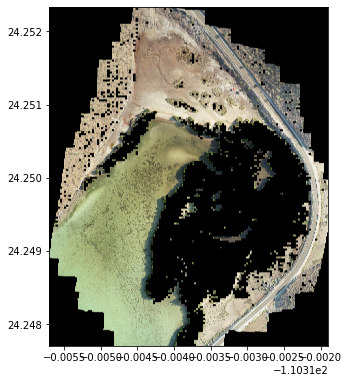

In [19]:
src = rasterio.open("1.tif")
fig, ax = plt.subplots(figsize=(5, 10))
rasterio.plot.show(src)

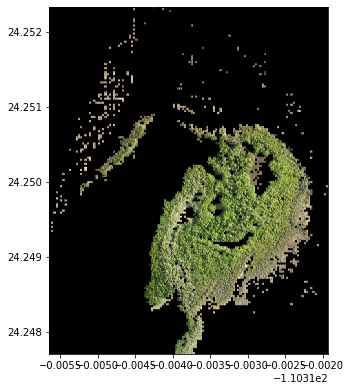

In [20]:
src = rasterio.open("0.tif")
fig, ax = plt.subplots(figsize=(5, 10))
rasterio.plot.show(src,ax=ax)